# Jigsaw Agile Community Rules Classification - EDA

This notebook performs an initial exploratory data analysis (EDA) on the competition dataset. The goal is to understand the data structure, distributions, and key patterns that will inform our modeling strategy.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

## 1. Load and Inspect Data

First, let's load the `train.csv`, `test.csv`, and `sample_submission.csv` files and take a look at their basic properties.

In [ ]:
import os

def load_if_exists(filepath):
    if os.path.exists(filepath):
        return pd.read_csv(filepath)
    else:
        print(f"Warning: {filepath} not found. Returning None.")
        return None

# Print shapes of loaded data
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Note: sample_submission.csv not found. This is only needed for final submission.
Train shape: (2029, 9)
Test shape: (10, 8)


## 2. Analyze Dataset Structure

In [15]:
print("Train columns:", train_df.columns.tolist())
print("Test columns:", test_df.columns.tolist())

print("Train data types:")
display(train_df.dtypes.to_frame().T)

print("Missing values in train:")
display(train_df.isnull().sum().to_frame().T)

print("First 5 rows of training data:")
display(train_df.head())

Train columns: ['row_id', 'body', 'rule', 'subreddit', 'positive_example_1', 'positive_example_2', 'negative_example_1', 'negative_example_2', 'rule_violation']
Test columns: ['row_id', 'body', 'rule', 'subreddit', 'positive_example_1', 'positive_example_2', 'negative_example_1', 'negative_example_2']
Train data types:


,row_id,body,rule,subreddit,positive_example_1,positive_example_2,negative_example_1,negative_example_2,rule_violation
0,int64,object,object,object,object,object,object,object,int64


Missing values in train:


,row_id,body,rule,subreddit,positive_example_1,positive_example_2,negative_example_1,negative_example_2,rule_violation
0,0,0,0,0,0,0,0,0,0


First 5 rows of training data:


,row_id,body,rule,subreddit,positive_example_1,positive_example_2,negative_example_1,negative_example_2,rule_violation
0,0,Banks don't want you to know this! Click here ...,"No Advertising: Spam, referral links, unsolici...",Futurology,If you could tell your younger self something ...,hunt for lady for jack off in neighbourhood ht...,Watch Golden Globe Awards 2017 Live Online in ...,"DOUBLE CEE x BANDS EPPS - ""BIRDS""\n\nDOWNLOAD/...",0
1,1,SD Stream [ ENG Link 1] (http://www.sportsstre...,"No Advertising: Spam, referral links, unsolici...",soccerstreams,[I wanna kiss you all over! Stunning!](http://...,LOLGA.COM is One of the First Professional Onl...,#Rapper \n🚨Straight Outta Cross Keys SC 🚨YouTu...,[15 Amazing Hidden Features Of Google Search Y...,0
2,2,Lol. Try appealing the ban and say you won't d...,No legal advice: Do not offer or request legal...,pcmasterrace,Don't break up with him or call the cops. If ...,It'll be dismissed: https://en.wikipedia.org/w...,Where is there a site that still works where y...,Because this statement of his is true. It isn'...,1
3,3,she will come your home open her legs with an...,"No Advertising: Spam, referral links, unsolici...",sex,Selling Tyrande codes for 3€ to paypal. PM. \n...,tight pussy watch for your cock get her at thi...,NSFW(obviously) http://spankbang.com/iy3u/vide...,Good News ::Download WhatsApp 2.16.230 APK for...,1
4,4,code free tyrande --->>> [Imgur](http://i.imgu...,"No Advertising: Spam, referral links, unsolici...",hearthstone,wow!! amazing reminds me of the old days.Well...,seek for lady for sex in around http://p77.pl/...,must be watch movie https://sites.google.com/s...,We're streaming Pokemon Veitnamese Crystal RIG...,1


## 3. Analyze Target Distribution (`rule_violation`)

Understanding the distribution of the target variable is crucial, especially for identifying class imbalance.

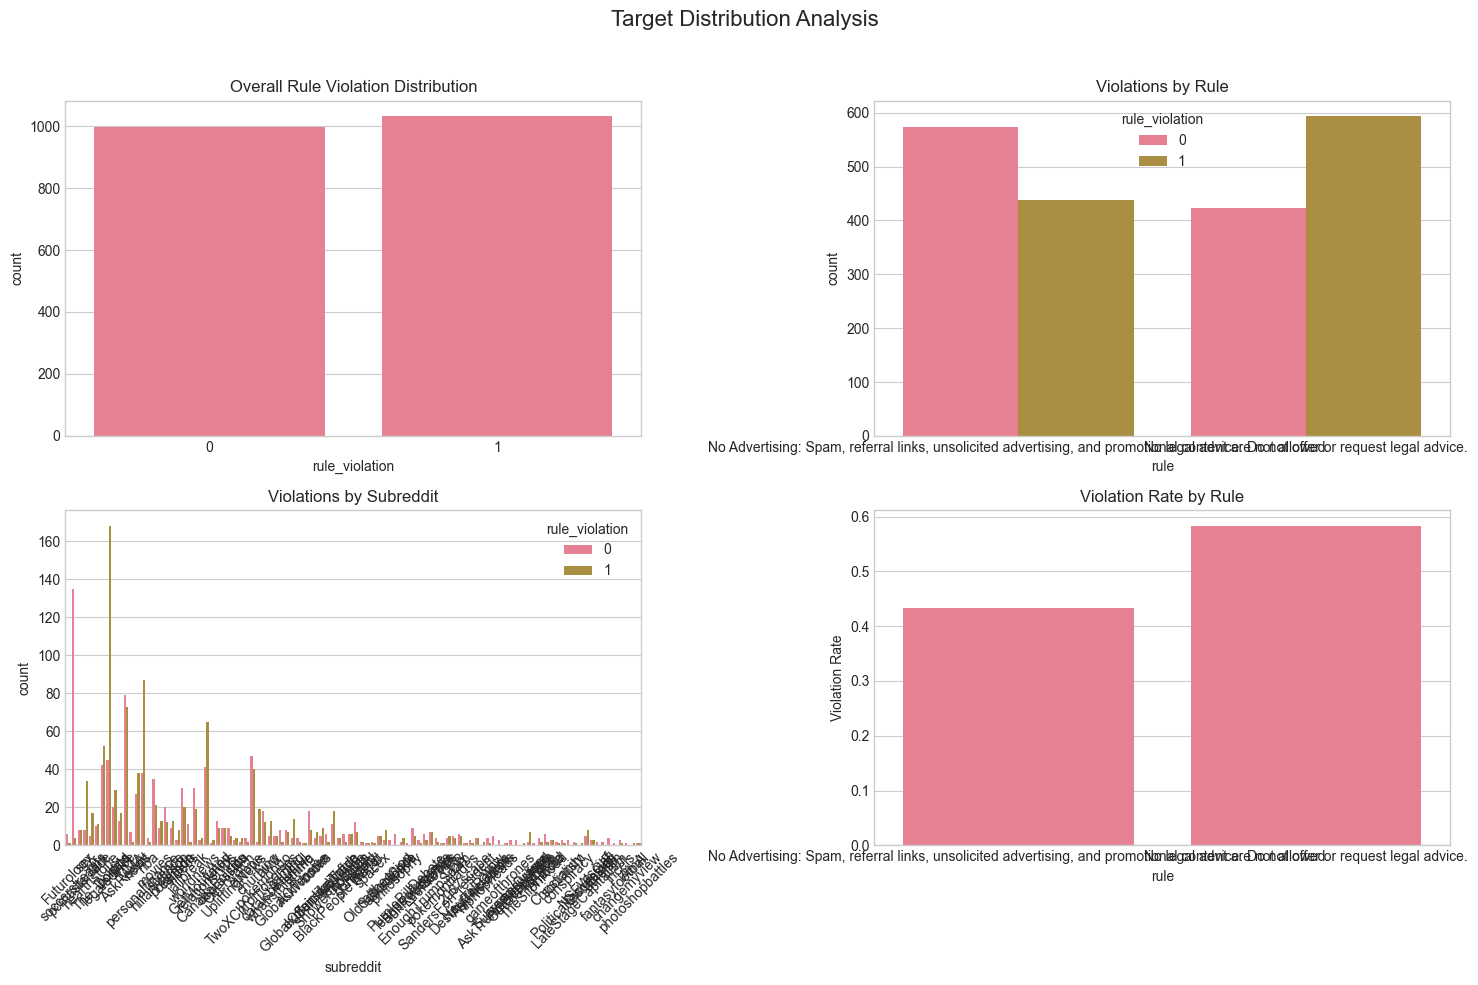

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Target Distribution Analysis', fontsize=16)

# Overall distribution
sns.countplot(x='rule_violation', data=train_df, ax=axes[0,0])
axes[0,0].set_title('Overall Rule Violation Distribution')

# By rule
sns.countplot(x='rule', hue='rule_violation', data=train_df, ax=axes[0,1])
axes[0,1].set_title('Violations by Rule')

# By subreddit
sns.countplot(x='subreddit', hue='rule_violation', data=train_df, ax=axes[1,0])
axes[1,0].set_title('Violations by Subreddit')
axes[1,0].tick_params(axis='x', rotation=45)

# Violation rate by rule
violation_rates = train_df.groupby('rule')['rule_violation'].mean().reset_index()
sns.barplot(x='rule', y='rule_violation', data=violation_rates, ax=axes[1,1])
axes[1,1].set_title('Violation Rate by Rule')
axes[1,1].set_ylabel('Violation Rate')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 4. Analyze Text Characteristics

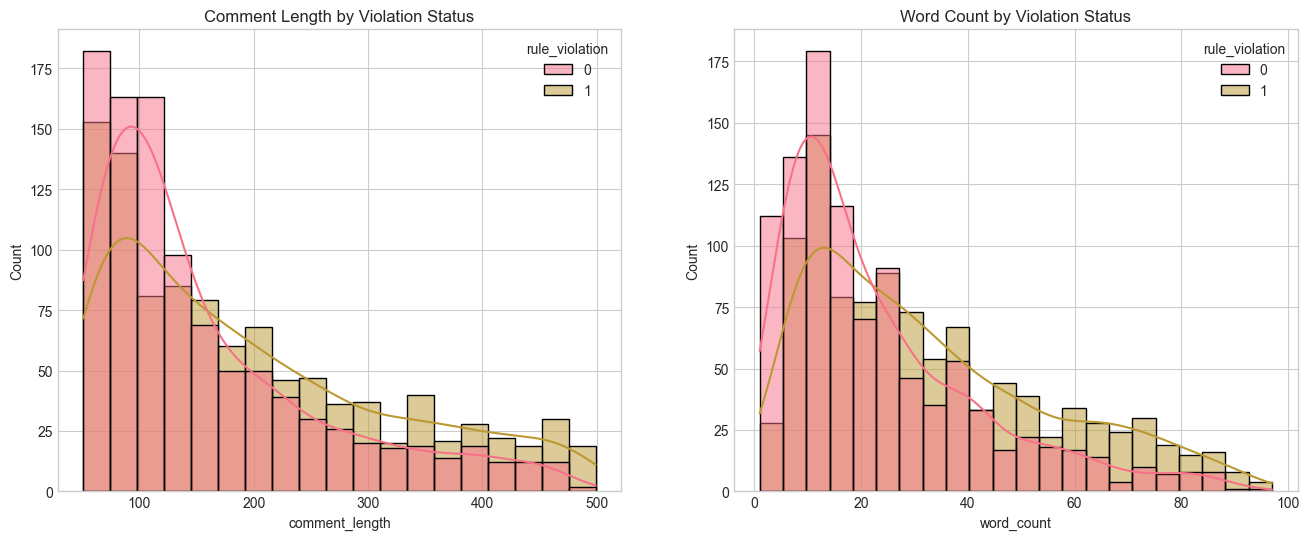

In [29]:
train_df['comment_length'] = train_df['body'].str.len()
train_df['word_count'] = train_df['body'].apply(lambda x: len(str(x).split()))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(data=train_df, x='comment_length', hue='rule_violation', kde=True, ax=axes[0])
axes[0].set_title('Comment Length by Violation Status')
sns.histplot(data=train_df, x='word_count', hue='rule_violation', kde=True, ax=axes[1])
axes[1].set_title('Word Count by Violation Status')
plt.show()

## 5. Analyze Rules and Examples

Let's examine the specific rules and the provided positive/negative examples. This is key for the few-shot learning approach.

In [28]:
unique_rules = train_df.drop_duplicates(subset=['rule'])

for _, row in unique_rules.iterrows():
    print(f"RULE: {row['rule']}")
    print(f"SUBREDDIT: {row['subreddit']}")
    print(f"-- POSITIVE EXAMPLE 1: {row['positive_example_1']}")
    print(f"-- POSITIVE EXAMPLE 2: {row['positive_example_2']}")
    print(f"-- NEGATIVE EXAMPLE 1: {row['negative_example_1']}")
    print(f"-- NEGATIVE EXAMPLE 2: {row['negative_example_2']}")
    print('-'*80)

RULE: No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed.
SUBREDDIT: Futurology
-- POSITIVE EXAMPLE 1: If you could tell your younger self something different about sex, what would that be?

i AM IN A CONTEST TO WIN FUNDING FOR MY SEX POSITIVE FILM: VOTE HERE:

http://sheknows.offerpop.com/campaign/813112/entry/v144417
-- POSITIVE EXAMPLE 2: hunt for lady for jack off in neighbourhood http://url.inmusi.com/gakq
-- NEGATIVE EXAMPLE 1: Watch Golden Globe Awards 2017 Live Online in HD Coverage without ADS (VIP STREAMS)
=

HD STREAM QUALITY >>> [WATCH LINK1](http://forum.submitexpress.com/viewtopic.php?f=9&t=215858)
=

HD BROADCASTING QUALITY >>> [WATCH LINK1](http://forum.submitexpress.com/viewtopic.php?f=9&t=215858)
=

Mobile Compatibility: YES
=

NO ADS | NO ADS | ADS
=

-- NEGATIVE EXAMPLE 2: DOUBLE CEE x BANDS EPPS - "BIRDS"

DOWNLOAD/STREAM:

http://music.theblacksmithed.com/download/birds/
------------------------------------------

## 6. Summary of Findings

Based on the analysis above, here are the key takeaways:

In [ ]:
violation_rate = train_df['rule_violation'].mean()
unique_rules_train = train_df['rule'].nunique()

print(f"Key Dataset Statistics:")
print(f"- Overall violation rate: {violation_rate:.2%}")
print(f"- Unique rules in training: {unique_rules_train}")

print(f"Key Challenges Identified:")
print(f"- Class imbalance is present but appears manageable.")
print(f"- The primary challenge is generalizing from {unique_rules_train} rules to unseen rules in the test set.")
print(f"- Text length and word count show some difference between classes, which could be useful features.")



Key Dataset Statistics:
- Overall violation rate: 50.81%
- Unique rules in training: 2
Key Challenges Identified:
- Class imbalance is present but appears manageable.
- The primary challenge is generalizing from 2 rules to unseen rules in the test set.
- Text length and word count show some difference between classes, which could be useful features.
Recommended Next Steps:
1. Implement a robust cross-validation strategy (e.g., StratifiedGroupKFold by rule).
2. Develop a preprocessing pipeline that handles Reddit-specific text (markdown, URLs, etc.).
3. Engineer features based on rule descriptions and examples.
4. Start with a strong baseline model (e.g., TF-IDF + LightGBM) and then move to transformer models.
